# Opening Data & libs


In [2]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pickle as pickle
from sklearn.preprocessing import LabelEncoder
from calendar import monthrange
import itertools
from tqdm import tqdm_notebook



In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Load the Data

In [77]:
transactions = pd.read_csv("Data/sales_train.csv")
items= pd.read_csv("Data/items.csv")
item_categories = pd.read_csv("Data/item_categories.csv")
shops = pd.read_csv("Data/shops.csv")
test = pd.read_csv("Data/test.csv", index_col = "ID")

In [78]:
for data_frame in [transactions ,items ,item_categories , shops ,test]:
    print (" Shape : {} \n head : {}\n".format(data_frame.shape,data_frame.head()))
    

 Shape : (2935849, 6) 
 head :          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0

 Shape : (22170, 3) 
 head :                                            item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3               

# Visualisation


#### Transactions
On a dans notre set "transactions" tous les tickets de caisses correspondants à la vente d'un item, dans un shop à une date donnée. 

In [79]:
transactions.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [80]:
print('Il y a {} mois dans le trainset.'.format(max(transactions.date_block_num.unique())))

Il y a 33 mois dans le trainset.


#### Test
On a dans notre set Test le mois 24 sans les ventes. Il s'agit de determiner les ventes d'un article dans un magasin precis.

In [81]:
test.head(2)

,shop_id,item_id
ID,,
0,5,5037
1,5,5320


In [82]:
print('On a {} shops et {} items dans le test set. \nPour un total de {} lignes.'
      .format(test.shop_id.nunique(),test.item_id.nunique(),test.shape[0]))

On a 42 shops et 5100 items dans le test set. 
Pour un total de 214200 lignes.


on remarque que 42*5100 = 214200

Ainsi, le test set a été construit en mprenants toutes les possibilités de combinaisons en prenant 42 shops et 5100 items. 

C'est une information très interessante, on va donc construire notre trainset de la même façon. 

### Pour observer plus de graphes, plus d'études de visualisation, se rendre dans le notebook "Visualization"

# Preprocessing 

#### Shops

Les noms de magasins sont en Russe, mais en cherchant un peu, on se rend compte que la première partie correspond à une ville(que l'on va encoder), la deuxième à un complexe : Centre commercial... (Que l'on va encoder egalement)


In [83]:
shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [84]:
# On a observé des magasins qui sont labelisés 2 fois.
transactions.loc[transactions.shop_id == 0, "shop_id"] = 57
test.loc[test.shop_id == 0 , "shop_id"] = 57
transactions.loc[transactions.shop_id == 1, "shop_id"] = 58
test.loc[test.shop_id == 1 , "shop_id"] = 58
transactions.loc[transactions.shop_id == 11, "shop_id"] = 10
test.loc[test.shop_id == 11, "shop_id"] = 10
transactions.loc[transactions.shop_id == 40, "shop_id"] = 39
test.loc[test.shop_id == 40, "shop_id"] = 39

## La première partie du nom de magasin est la ville, on va encoder son zip code 
#Correction pour un ville en 2 partie. 
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'

shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
# ET on encode
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])

# Liste correspondante aux valeurs : ["Centre commercial", "centre commercial", "centre commercial", "commerce",«Urgences», «MTRC», «Shop», «TK»,«entrepôt»]
# Qui correspondent au type de magasin, que l'on trouve dans la deuxième partie du split. 
shops["complex"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
complex_list = ['ТЦ', 'ТРК', 'ТРЦ', 'ТК']

# On applique cette transformation et on met other sur le reste. 
shops['complex_code'] = shops.complex.map(lambda x: x if x in complex_list else 'other')

# Et on encode ! 
shops['complex_code'] = LabelEncoder().fit_transform(shops['complex_code'])

shops = shops[['shop_id','city_code','complex_code']]
shops.head(2)

,shop_id,city_code,complex_code
0,0,29,0
1,1,29,4


#### Item categories

 La categorie de jeu est ecrite ainsi : type - sous type. On va donc extraire le type puis le sous titre et les encoder


In [85]:
item_categories.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [86]:

# La categorie de jeu est ecrite ainsi : type - sous type. On va donc extraire le type puis le sous titre
item_categories['split'] = item_categories['item_category_name'].str.split('-')

item_categories['type'] = item_categories['split'].map(lambda x: x[0])

# On ne va encoder que les catégories significativement grandes. 

category = []
for cat in item_categories.type.unique():
    if len(item_categories[item_categories.type == cat]) > 4: 
        category.append( cat )

        
item_categories['type'] = item_categories['type'].map(lambda x: x.strip() if x in category else 'other')
item_categories['type_code'] = LabelEncoder().fit_transform(item_categories['type'])

#Sous type
item_categories['subtype'] = item_categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_categories['subtype_code'] = LabelEncoder().fit_transform(item_categories['subtype'])

item_categories = item_categories[['item_category_id','type_code', 'subtype_code']]

item_categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9


In [87]:
print('On a {} villes differentes, {} types et {} sous types de categories'
     .format(shops.city_code.nunique(),item_categories.type_code.nunique(),item_categories.subtype_code.nunique()))

On a 31 villes differentes, 9 types et 65 sous types de categories


#### Item name

Les noms d'items ont été volontairement abimés, il faut donc les corriger pour faire disparaitre les caractères sauvages. 

On va ensuite decomposer le nom pour faire apparaitre des categories (ex : PSP, XBOX...) 
En étudiant la structure du nom, il est en 3 parties, on va les faire aparaitre. 


In [88]:
items.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [89]:
import re
# Cette fonction nous sert à decoder le nom.
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x


items["name1"], items["name2"] = items.item_name.str.split("[", 1).str
items["name1"], items["name3"] = items.item_name.str.split("(", 1).str

items["name2"] = items.name2.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items["name3"] = items.name3.str.replace('[^A-Za-z0-9А-Яа-я]+', " ").str.lower()
items = items.fillna('0')

items["item_name"] = items["item_name"].apply(lambda x: name_correction(x))
items.name2 = items.name2.apply( lambda x: x[:-1] if x !="0" else "0")

items["type"] = items.name2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "рс"), "type" ] = "pc"
items.loc[(items.type == 'рс' )|(items.type == 'pc' ),'type']= 'pc'
items.loc[ items.type == 'рs3' , "type"] = "ps3"

group_sum = items.groupby(["type"]).agg({"item_id": "count"}).reset_index()

drop_type = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_type.append(cat)
        
items.name2 = items.name2.apply( lambda x: "etc" if (x in drop_type) else x )
items.type = items.type.apply( lambda x: "etc" if (x in drop_type) else x )

# Et on encode
items.name2 = LabelEncoder().fit_transform(items.name2)
items.name3 = LabelEncoder().fit_transform(items.name3)
items.type = LabelEncoder().fit_transform(items.type)

items.drop(["item_name", "name1"],axis = 1, inplace= True)
items.head(2)


C:\Users\leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  del sys.path[0]
C:\Users\leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


,item_id,item_category_id,name2,name3,type
0,0,40,4,1331,0
1,1,76,64,42,3


### Construisons le train data set

On met item_count_day à Zero les retours de produits (<0) Car ils contiennent des informations sur le prix de retour. et c'est assez precieux


In [90]:
# On elève les Outliers 

transactions = transactions.loc[transactions.item_price<100000]
transactions = transactions.loc[transactions.item_price> 0]
transactions = transactions.loc[transactions.item_cnt_day<1001 ]
# On met à Zero les retours de produits (Car ils contiennent des informations sur le prix de retour.)
transactions.loc[transactions.item_cnt_day < 1, "item_cnt_day"] = 0


# Transformations sur les dates
transactions.date = pd.to_datetime(transactions.date, format='%d.%m.%Y')
transactions.date_index = pd.DatetimeIndex(transactions['date'])
transactions['month'] = transactions.date_index.month
transactions['year'] = transactions.date_index.year
transactions['max_days'] = transactions.date_index.daysinmonth

transactions.head(2)

C:\Users\leo\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,month,year,max_days
0,2013-01-02,0,59,22154,999.0,1.0,1,2013,31
1,2013-01-03,0,25,2552,899.0,1.0,1,2013,31


# Feature generation

On va donc, comme on l'a vu en première partie, gréer une grille avec toutes les possibilitées de ventes pour chaque mois et on va ensuite merge avec les donnes que l'on a. 


In [91]:
data = pd.DataFrame(transactions.groupby(['date_block_num','shop_id','item_id','month','year','max_days'])['item_cnt_day'].sum())
data.reset_index(inplace=True)

## On va construire un grid, avec toutes les possibilitées de ventes 

### Matrix

import itertools
data_full = []
for i in range(34):
    data_list_1 = data[data.date_block_num==i].date_block_num.unique().tolist()
    data_list_2 = data[data.date_block_num==i].shop_id.unique().tolist()
    data_list_3 = data[data.date_block_num==i].item_id.unique().tolist()

    data_list_f1=list(itertools.product(data_list_1,data_list_2,data_list_3))
    data_full.append(data_list_f1)


data_full = pd.DataFrame(np.vstack(data_full) )
data_full.rename(columns={0: "date_block_num", 1: "shop_id", 2: "item_id"} , inplace = True)

data_full["date_block_num"] = data_full["date_block_num"].astype(np.int8)
data_full["shop_id"] = data_full["shop_id"].astype(np.int8)
data_full["item_id"] = data_full["item_id"].astype(np.int16)

data_full.head(2)

,date_block_num,shop_id,item_id
0,0,2,27
1,0,2,33


On ajoute des variabes sur le temps et on concatenate avec le test set

In [92]:
#### Time

# On va ajouter les jours ouvrés. Le calcul étant copieux, on va construire un sous tableau de dates et ensuite merge. 
data_time = data[['date_block_num','month','year','max_days']].drop_duplicates()
data_time['busy_days']  = [np.busday_count(dt.date(year=int(x[1].year), month=int(x[1].month), day=1),dt.date(year=int(x[1].year), month=int(x[1].month), day=int(x[1].max_days))) for x in data_time.iterrows()]
data = data.drop(['month','year','max_days'],axis = 1)
data_full = data_full.merge(data_time,left_on = 'date_block_num',right_on = 'date_block_num',how = 'left')
del data_time

## J'ajoute pour l'instant le test set au bout pour produire les bonnes variables test
test['date_block_num']= 34
test['month'] = 11
test['year'] = 2015
test['max_days'] = 30
test['busy_days']  = np.busday_count(dt.date(year=2015, month=11, day=1),dt.date(year=2015, month= 11, day=30))

test = test[['date_block_num', 'shop_id', 'item_id', 'month', 'year', 'max_days', 'busy_days']]

## Concatenation
data_full = pd.concat([data_full, test]).reset_index(drop=True)

# On ajoute à notre grand tableau les ventes precedement calculées 
data_full = data_full.merge(data,on = ['date_block_num','shop_id','item_id'],how = 'left')


#### Target
#On a beaucoup de valeurs nulles ( 85%), alors, on fill avec des Zeros car pas de ventes? Et on clip les ventes dans (0,20)
data_full = data_full.rename(columns = {'item_cnt_day' : 'Y'})
data_full['Y'] = (data_full['Y'].fillna(0)
                                .clip(0,20) 
                                .astype(np.float32))

# On ne garde que data_full dans data. 
data = data_full.copy()
del data_full

data.head(2)

,date_block_num,shop_id,item_id,month,year,max_days,busy_days,Y
0,0,2,27,1,2013,31,22,1.0
1,0,2,33,1,2013,31,22,1.0


Une fois que l'on a fait ça, on merge avec les tableaux que l'on a precedement calculé ! 

In [93]:
#### Merging 

# J'ajoute les villes des magasins
data = data.merge(shops,left_on = 'shop_id',right_on = 'shop_id', how = 'left')

# J'ajoute les categories des produits
data = data.merge(items,on = 'item_id', how = 'left')
#data = data.drop('item_name',axis =1)

# J'ajoute les sous-categories des produits
data = data.merge(item_categories,left_on = 'item_category_id',right_on = 'item_category_id', how = 'left')

data.head(2)

,date_block_num,shop_id,item_id,month,year,max_days,busy_days,Y,city_code,complex_code,item_category_id,name2,name3,type,type_code,subtype_code
0,0,2,27,1,2013,31,22,1.0,0,4,19,76,42,5,3,10
1,0,2,33,1,2013,31,22,1.0,0,4,37,4,562,0,4,1


## Price calculation 
Une composante essentielle des ventes est le prix. On va créer quelques features correspondantes.

In [94]:
### Price

# Prix moyen total du produit
group = transactions.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

data = data.merge( group, on = ["item_id"], how = "left" )
data["item_avg_item_price"] = data.item_avg_item_price.astype(np.float16)


# Prix moyen sur la periode du produit
group = transactions.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

data = data.merge(group, on = ["date_block_num","item_id"], how = "left")
data["date_item_avg_item_price"] = data.date_item_avg_item_price.astype(np.float16)



### Save
# On n'a plus besoin des transactions pour le moment, on libère la mémoire
pickle.dump(transactions, open('Pickle_save/transactions', 'wb'))
del transactions
data.head(2)

,date_block_num,shop_id,item_id,month,year,max_days,busy_days,Y,city_code,complex_code,item_category_id,name2,name3,type,type_code,subtype_code,item_avg_item_price,date_item_avg_item_price
0,0,2,27,1,2013,31,22,1.0,0,4,19,76,42,5,3,10,1461.000,2324.0
1,0,2,33,1,2013,31,22,1.0,0,4,37,4,562,0,4,1,252.875,488.5


Il peut être important de savoir si c'est la première fois qu'un magasin vend ce produit ! On va print un exemple de produit qui est nouveau dans le test set. 

In [95]:
data["item_shop_first_sale"] = data["date_block_num"] - data.groupby(["item_id","shop_id"])["date_block_num"].transform('min')
data["item_first_sale"] = data["date_block_num"] - data.groupby(["item_id"])["date_block_num"].transform('min')
data.loc[(data.date_block_num == 34)&(data.item_id == 5320)].head(2)

,date_block_num,shop_id,item_id,month,year,max_days,busy_days,Y,city_code,complex_code,item_category_id,name2,name3,type,type_code,subtype_code,item_avg_item_price,date_item_avg_item_price,item_shop_first_sale,item_first_sale
10842078,34,5,5320,11,2015,30,20,0.0,3,3,55,4,42,0,6,2,NaN,NaN,0,0
10847178,34,4,5320,11,2015,30,20,0.0,2,4,55,4,42,0,6,2,NaN,NaN,0,0


# Feature generation - Lags

On s'interesse aux ventes des mois precedents : l'annee derniere, le mois dernier, 2 mois avant et 6 mois avant

In [96]:
def lag_feature(df, lags, col,mean_lag = False):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    
    names = [col+'_lag_'+str(i) for i in [1,2,3]]
    if mean_lag : 
        df[col+'_lag_mean'] = np.round(df[names].mean(axis = 1))
        
    return df


data=  lag_feature(data, [1,2,3,4,5,12], 'Y',mean_lag = True)
data = reduce_mem_usage(data)
data.loc[data.date_block_num == 33].head(2)

Mem. usage decreased to 516.66 Mb (67.8% reduction)


,date_block_num,shop_id,item_id,month,year,max_days,busy_days,Y,city_code,complex_code,...,date_item_avg_item_price,item_shop_first_sale,item_first_sale,Y_lag_1,Y_lag_2,Y_lag_3,Y_lag_4,Y_lag_5,Y_lag_12,Y_lag_mean
10603905,33,2,31,10,2015,31,22,1.0,0,4,...,376.75,32,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10603906,33,2,486,10,2015,31,22,3.0,0,4,...,298.00,13,13,1.0,0.0,0.0,2.0,0.0,1.0,0.0


### Price

In [97]:
lags = [1, 2, 3]

data = lag_feature( data, lags, "date_item_avg_item_price" , mean_lag=True)

for i in lags:
    data["delta_price_lag_" + str(i) ] = (data["date_item_avg_item_price_lag_" + str(i)]- data["item_avg_item_price"] )/ data["item_avg_item_price"]

def select_trends(row) :
    for i in (lags):
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

data["delta_price_lag"] = data.apply(select_trends, axis = 1)
data["delta_price_lag"] = data.delta_price_lag.astype( np.float16 )
data["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in tqdm_notebook(lags):
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
data.drop(features_to_drop, axis = 1, inplace = True)

data.loc[data.date_block_num == 34].head(2)

C:\Users\leo\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\leo\Anaconda3\lib\site-packages\pandas\core\nanops.py:116: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)
C:\Users\leo\Anaconda3\lib\site-packages\numpy\core\_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


A Jupyter Widget

,date_block_num,shop_id,item_id,month,year,max_days,busy_days,Y,city_code,complex_code,...,item_first_sale,Y_lag_1,Y_lag_2,Y_lag_3,Y_lag_4,Y_lag_5,Y_lag_12,Y_lag_mean,date_item_avg_item_price_lag_mean,delta_price_lag
10842077,34,5,5037,11,2015,30,20,0.0,3,3,...,14,0.0,1.0,3.0,1.0,1.0,1.0,1.0,1112.0,-0.222046
10842078,34,5,5320,11,2015,30,20,0.0,3,3,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


## D'autres Lags
On va calculer d'autres Lags correspondants à des moyennes de ventes en groupant par colonnes. 

In [98]:
col_list = [['date_block_num'],['date_block_num','item_id'],
            ['date_block_num', 'shop_id'],['date_block_num', 'item_category_id'],
            ['date_block_num', 'city_code'],['date_block_num', 'item_id', 'city_code'],
            ['date_block_num', 'type_code'],['date_block_num', 'subtype_code'],
            ['date_block_num', 'shop_id', 'item_category_id'], ['date_block_num', 'shop_id', 'item_id']]

for col_name in tqdm_notebook(col_list) :
    name = '_'.join(col_name) + '_avg_Y'
    print('Processing {}.'.format(name))
    
    group = data.groupby(col_name).agg({'Y': ['mean']})
    group.columns = [ name ]
    group.reset_index(inplace=True)

    data = data.merge(group, on= col_name, how='left')
    #Je fais le choix d'encoder avec des entiers, qui sont moins gourmands en mémoire que les floats
    #data[name] = (data[name]*500).astype(np.int)
    data = lag_feature(data, [1], name)
    # pour cela, on va chercher des lags plus anciens car ils sont importants ! 
    if col_name in [['date_block_num','item_id'],['date_block_num', 'shop_id'],['date_block_num', 'item_category_id'],['date_block_num', 'shop_id', 'item_id']]:
        data = lag_feature(data, [2,3], name,mean_lag = True
                          )
    data.drop([name], axis=1, inplace=True)

    

A Jupyter Widget

Processing date_block_num_avg_Y.
Processing date_block_num_item_id_avg_Y.


C:\Users\leo\Anaconda3\lib\site-packages\pandas\core\nanops.py:116: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


Processing date_block_num_shop_id_avg_Y.
Processing date_block_num_item_category_id_avg_Y.
Processing date_block_num_city_code_avg_Y.
Processing date_block_num_item_id_city_code_avg_Y.
Processing date_block_num_type_code_avg_Y.
Processing date_block_num_subtype_code_avg_Y.
Processing date_block_num_shop_id_item_category_id_avg_Y.
Processing date_block_num_shop_id_item_id_avg_Y.



On peut prendre d'autres statistiques, comme la médiane.

In [99]:
col_list = [['date_block_num', 'shop_id'], ['date_block_num', 'shop_id','item_category_id']]

for col_name in tqdm_notebook(col_list) :
    name = '_'.join(col_name) + '_median_Y'
    print('Processing {}.'.format(name))

    
    group = data.groupby(col_name).agg({'Y': ['median']})
    group.columns = [ name ]
    group.reset_index(inplace=True)

    data = data.merge(group, on= col_name, how='left')
    
    #Je fais le choix d'encoder avec des entiers, qui sont moins gourmands en mémoire que les floats
    #data[name] = (data[name]*500).astype(np.int)
    data = lag_feature(data, [1], name)
    
    if col_name in [['date_block_num', 'shop_id']]:
        
        data = lag_feature(data, [2,3], name,mean_lag = True)
    
    data.drop([name], axis=1, inplace=True)

A Jupyter Widget

Processing date_block_num_shop_id_median_Y.


C:\Users\leo\Anaconda3\lib\site-packages\pandas\core\nanops.py:116: RuntimeWarning: Mean of empty slice
  result = bn_func(values, axis=axis, **kwds)


Processing date_block_num_shop_id_item_category_id_median_Y.



In [100]:
### Important : on enlève la partie test, qui va nous géner pour le mean encoding. 
# On fillna pour le X_test car les Nan correspondent à des nouveaux produits, donc leurs previous ventes sont nulles
data = reduce_mem_usage(data)
pickle.dump(data, open('Pickle_save/data_lags', 'wb'))
print(data.shape)
X_test = data.loc[data.date_block_num == 34].drop(['Y'], axis=1)
pickle.dump(X_test,open('Pickle_save/X_test', 'wb'))
print(X_test.shape)


Mem. usage decreased to 1149.31 Mb (-5.8% reduction)


### Encodage des variables categoriques 

Essai pour encoder les variabe catégoriques en utilisant l'expanding mean. 
--> Je n'ai pas gardé l'encodage pour le resultat final. (Overfitting enorme)

In [27]:
data = data.loc[data.date_block_num < 34]

# J'utilise la moyenne expanding, pour eviter l'overfitting. C'est très adapté pour les grands nombres de categories. 
def col_target_enc_expand(df,col):
    
    cumsum = df.groupby(col)['Y'].cumsum() - df['Y']
    cumcount = df.groupby(col).cumcount()
    # On ajoute 1 car la fonction cumcount commence à 0 dans pandas
    return np.round((cumsum / (cumcount+1))*500)


cols = [['item_id'],
        ['shop_id','item_id'],
        ['shop_id'],
        ['city_code'],
        ['complex_code'],
        ['item_category_id'],
        ['type_code'],
        ['subtype_code'],
        ['month'],
       ['name2'],
       ['name3']]

mean = 0.246149

for col in tqdm_notebook(cols) :
    name_mean = '_'.join(col)+'_target_enc_expand'
    data[name_mean] = col_target_enc_expand(data,col)
    data[name_mean].replace(np.inf, mean, inplace=True)


data = reduce_mem_usage(data)
pickle.dump(data,open('Pickle_save/encoded','wb'))



col_data = list(data)
col_data.remove('Y')
col_test = list(X_test)
keys = ['item_id','shop_id'] 
expands = list(set(col_data) - set(col_test))

cols_to_use = keys + expands 

gb = X_test.merge(data[cols_to_use],on = keys ,how ='left')
gb = gb.groupby(keys)[expands].median()
gb.reset_index(inplace = True)


X_test = X_test.merge(gb,on = keys ,how ='left')
X_test = X_test[col_data]
pickle.dump(X_test, open('Pickle_save/model_test', 'wb'))

## Model Fit

In [43]:
data =pickle.load(open('Pickle_save/data_lags','rb'))
data = data[data.date_block_num < 34]
data = data[data.date_block_num > 12]

test = pickle.load(open('Pickle_save/X_test','rb'))
test = test.reset_index(drop=True)

In [44]:
cols_to_keep = pickle.load(open("Pickle_save/cols_to_keep",'rb'))


X_train = data[data.date_block_num < 33].drop(['Y'], axis=1)[cols_to_keep]
Y_train = data[data.date_block_num < 33]['Y']
X_valid = data[data.date_block_num == 33].drop(['Y'], axis=1)[cols_to_keep]
Y_valid = data[data.date_block_num == 33]['Y']

test = test[cols_to_keep]

In [7]:
X_train = data[data.date_block_num < 33].drop(['Y'], axis=1)
Y_train = data[data.date_block_num < 33]['Y']
X_valid = data[data.date_block_num == 33].drop(['Y'], axis=1)
Y_valid = data[data.date_block_num == 33]['Y']


In [45]:
import lightgbm as lgb

lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=Y_train), num_boost_round = 200,valid_sets = lgb.Dataset(X_valid, label=Y_valid),early_stopping_rounds = 10,verbose_eval =True)



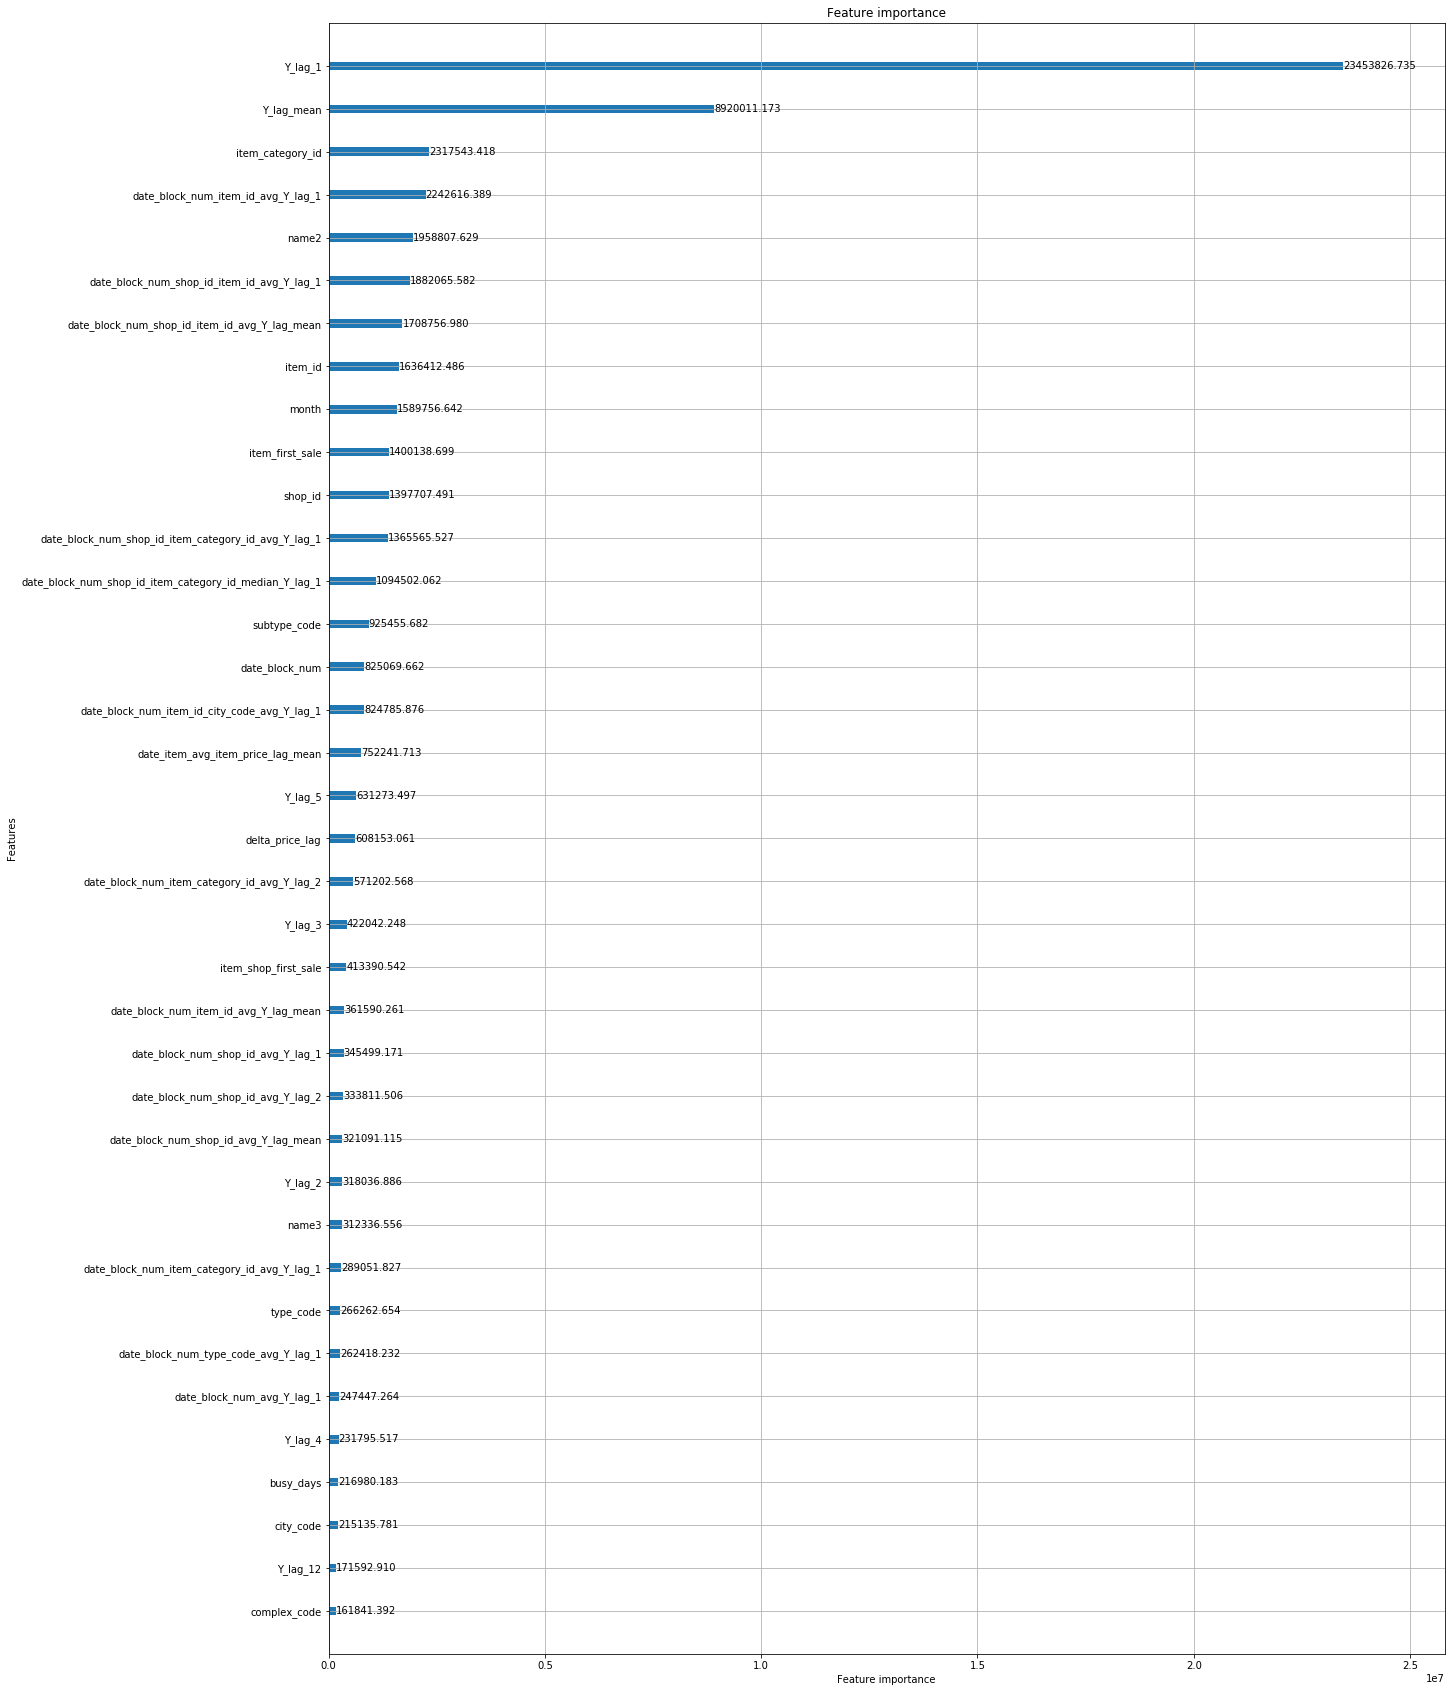

In [46]:
pickle.load(open('Pickle_save/model2','rb'))
lgb.plot_importance(model,figsize = (20,30),importance_type = 'gain')
plt.show()

In [19]:

importance = model.feature_importance(importance_type='gain')
feature_name = model.feature_name()

feature_importance = pd.DataFrame({'feature_name':feature_name,'importance':importance} ).sort_values('importance', ascending=False)
feature_importance.head(26)
#feature_importance.to_csv('feature_importance.csv',index=False)
cols_to_keep = feature_importance.feature_name.values[:37]
#len(cols_to_keep)
pickle.dump(cols_to_keep, open('Pickle_save/cols_to_keep', 'wb'))


In [20]:
pickle.dump(model, open('Pickle_save/model2', 'wb'))


In [47]:
result = model.predict(test)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": result.clip(0, 20)
})
submission = submission.set_index('ID')
submission.to_csv('Results/submission4.csv')


In [48]:
result

array([0.54965266, 0.45389057, 1.33351723, ..., 0.05334535, 0.03043541,
       0.05264771])